<a href="https://colab.research.google.com/github/HAR5HA-7663/MCS-5993-Evolutionary-Computation-and-Deep-Learning/blob/main/Extra_credit/JenaWeather_Seq2Seq_EA_with_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-step Seq2Seq Time-Series Forecasting using Dual Evolutionary Algorithms on Jena Weather Dataset

**Author:** V Harsha Yellela  
**LTU ID:** 000798754  
**Course:** MCS-5993 Evolutionary Computation & Deep Learning  
**Project Type:** Extra Credit Project  
**AI Assistance:** ~25% (used for structure, EA integration ideas; all code was understood and adapted by me)

---

In this notebook I am experimenting with **sequence-to-sequence (Seq2Seq)** models and **evolutionary strategies** for time-series forecasting.

I use the **Jena Weather Dataset** and try to:

1. Use past weather data (72 hours) to predict the next 6 hours (multi-step horizon).  
2. Build an **encoder–decoder LSTM** model (Seq2Seq).  
3. Optimize the model in **two ways**:
   - A **Genetic Algorithm (GA)** to search for good hyperparameters (LSTM units, learning rate, dropout).
   - An **ES(1+1) with 1/5 success rule** to fine-tune the final layer weights after training.

Since I am still learning deep learning and evolutionary algorithms, I focus on writing clear steps and comments so I can come back later and remember what I did and why.


## 1. Import Required Libraries and Configure Environment

In this section I import the libraries, set random seeds, and configure the GPU (if available). I also enable mixed precision if supported, since this can speed up training on modern GPUs.


In [13]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras import optimizers

import random
import os
import time

# GPU configuration: allow memory growth and detect GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print(f"GPUs detected: {len(gpus)} - memory growth enabled.")
    except Exception as e:
        print("Could not set memory growth:", e)
else:
    print("No GPU detected. Running on CPU.")

# Mixed precision for faster GPU training (if supported)
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled (float16 compute, float32 variables).")
except Exception as e:
    print("Mixed precision not enabled:", e)

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


GPUs detected: 1 - memory growth enabled.
Mixed precision enabled (float16 compute, float32 variables).


## 2. Load & Preprocess the Jena Weather Dataset

Here I:

- Load the CSV file.
- Clean missing values (if any).
- Select a small set of core weather features.
- Standardize the features so the neural network trains more smoothly.

> **Note:** I assume the file is called `WeatherJena.csv` and is located in the same folder as this notebook. If not, I can update the `csv_path` variable.


In [14]:
import kagglehub
import os # Import os module for path manipulation

# Download latest version
path = kagglehub.dataset_download("harishedison/jena-weather-dataset")

# Construct the full path to the CSV file within the downloaded directory
# Assuming the CSV file is named 'WeatherJena.csv' based on commented out line
csv_path = os.path.join(path, 'WeatherJena.csv')
df = pd.read_csv(csv_path)

print("Original shape:", df.shape)
df.head()


Using Colab cache for faster access to the 'jena-weather-dataset' dataset.
Original shape: (656956, 22)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),CO2 (ppm)
0,01.01.2010 00:10:00,967.56,-2.84,272.89,-3.41,95.8,4.95,4.75,0.21,3.06,...,1.61,2.76,15.41,0.0,0,0.0,0.0,0.0,8.59,404.6
1,01.01.2010 00:20:00,967.45,-2.85,272.88,-3.43,95.7,4.95,4.74,0.21,3.05,...,2.00,3.10,17.04,0.0,0,0.0,0.0,0.0,8.53,404.1
2,01.01.2010 00:30:00,967.45,-2.88,272.85,-3.46,95.8,4.94,4.73,0.21,3.05,...,2.25,3.79,25.35,0.0,0,0.0,0.0,0.0,8.52,404.3
3,01.01.2010 00:40:00,967.34,-2.90,272.84,-3.47,95.8,4.93,4.72,0.21,3.04,...,2.64,3.77,23.64,0.0,270,0.0,0.0,0.0,8.54,404.0
4,01.01.2010 00:50:00,967.29,-2.96,272.78,-3.53,95.8,4.91,4.70,0.21,3.03,...,2.82,4.29,18.94,0.0,310,0.0,0.0,0.0,8.55,401.9


In [15]:
# Basic cleaning: replace -200 with NaN (if present) and drop NaNs
df = df.replace(-200, np.nan).dropna()
print("After dropping NaNs:", df.shape)

# Select a subset of relevant features
features = ["T (degC)", "p (mbar)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)"]
data = df[features].values

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

print("Data scaled shape:", data_scaled.shape)


After dropping NaNs: (656956, 22)
Data scaled shape: (656956, 5)


## 3. Create Lagged Sequences (Windowing)

For Seq2Seq forecasting I need:

- **Input sequence:** past 72 hours (3 days) of weather data.  
- **Output sequence:** next 6 hours of weather.

I slide a window over the time-series and build `(X, y)` pairs:

- `X[i]` = 72×features  
- `y[i]` = 6×features  


In [16]:
# Define past and future window sizes
past_steps = 24 * 3   # 72 time steps (3 days of hourly data)
future_steps = 6      # Predict next 6 hours

def create_seq2seq_data(dataset, past_steps, future_steps):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

X, y = create_seq2seq_data(data_scaled, past_steps, future_steps)
print("X shape:", X.shape)
print("y shape:", y.shape)

# Split into Train / Validation / Test sets (60% / 20% / 20%)
n = len(X)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


X shape: (656878, 72, 5)
y shape: (656878, 6, 5)
Training data shape: (394126, 72, 5), (394126, 6, 5)
Validation data shape: (131376, 72, 5), (131376, 6, 5)
Test data shape: (131376, 72, 5), (131376, 6, 5)


## 4. Build Seq2Seq LSTM Model

I use a simple encoder–decoder LSTM:

- **Encoder:** reads the past 72 time steps and compresses them into hidden states.
- **Decoder:** starts from the encoder states and predicts 6 future steps.
- **TimeDistributed Dense:** maps each decoder output to the 5 weather features.

This matches the Seq2Seq idea from class (time-series → time-series).


In [17]:
def build_seq2seq(n_features, n_past, n_future, n_units=64, dropout_rate=0.2):
    # Encoder
    encoder_inputs = Input(shape=(n_past, n_features))
    encoder_lstm = LSTM(n_units, activation='tanh', return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = RepeatVector(n_future)(encoder_outputs)
    decoder_lstm = LSTM(n_units, activation='tanh', return_sequences=True)(
        decoder_inputs, initial_state=encoder_states
    )

    # Optional dropout on decoder outputs
    if dropout_rate and dropout_rate > 0:
        decoder_lstm = Dropout(dropout_rate)(decoder_lstm)

    # TimeDistributed Dense to generate multi-step, multi-feature outputs
    # Force final predictions to float32 so mixed precision does not confuse metrics later
    decoder_outputs = TimeDistributed(Dense(n_features, dtype='float32'))(decoder_lstm)

    model = Model(encoder_inputs, decoder_outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Quick check
n_features = X.shape[2]
base_model = build_seq2seq(n_features=n_features, n_past=past_steps, n_future=future_steps)
base_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 72, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 64),      │     17,920 │ input_layer_2[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 6, 64)     │          0 │ lstm_4[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 6, 64)     │     33,024 │ repeat_vector_2[… │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 6, 64)     │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 6, 5)      │        325 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Genetic Algorithm (GA) for Hyperparameter Search

I use a **Genetic Algorithm** as an outer-loop optimizer to search over:

- Number of LSTM units (32–128)
- Learning rate (0.0005–0.01)
- Dropout rate (0.1–0.5)

To keep the search fast enough, I:

- Use only a small subset of the training data for fitness evaluation.
- Train each candidate for a few epochs.
- Use selection, crossover, and mutation to evolve the population.


In [18]:
def GA_optimize(pop_size=4, generations=3, subset_ratio=0.08, epochs_per_eval=2):
    """Genetic Algorithm for hyperparameter optimization."""
    # Choose a subset of training data for speed
    subset_size = max(2048, int(len(X_train) * subset_ratio))
    X_train_subset = X_train[:subset_size]
    y_train_subset = y_train[:subset_size]

    print(f"Using {subset_size}/{len(X_train)} samples for GA fitness evaluation")
    print(f"Subset ratio ≈ {100*subset_ratio:.1f}% of training data\n")

    # Initialize population
    population = []
    for _ in range(pop_size):
        # [units, lr, dropout]
        ind = [
            random.randint(32, 128),        # LSTM units
            random.uniform(0.0005, 0.01),   # Learning rate
            random.uniform(0.1, 0.5)        # Dropout rate
        ]
        population.append(ind)

    best_losses_over_gens = []

    def fitness(ind):
        """Train a small model and return final training loss as fitness."""
        units, lr, dropout = ind
        tf.keras.backend.clear_session()

        model = build_seq2seq(
            n_features=X.shape[2],
            n_past=past_steps,
            n_future=future_steps,
            n_units=int(units),
            dropout_rate=dropout
        )
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='mse')

        subset_batch = 512
        ds = tf.data.Dataset.from_tensor_slices(
            (X_train_subset.astype('float32'), y_train_subset.astype('float32'))
        )
        ds = ds.batch(subset_batch).prefetch(tf.data.AUTOTUNE)

        history = model.fit(ds, epochs=epochs_per_eval, verbose=0)
        return history.history['loss'][-1]

    for gen in range(generations):
        print(f"Generation {gen+1}/{generations}:")
        scores = []
        for i, ind in enumerate(population):
            score = fitness(ind)
            scores.append(score)
            print(f"  Individual {i+1}: Loss={score:.4f}, Units={int(ind[0])}, LR={ind[1]:.6f}, Dropout={ind[2]:.3f}")

        num_parents = max(2, pop_size // 2)
        ranked = [x for _, x in sorted(zip(scores, population), key=lambda pair: pair[0])]
        population = ranked[:num_parents]

        best_loss = min(scores)
        best_losses_over_gens.append(best_loss)
        print(f"  → Best Loss this generation: {best_loss:.4f}\n")

        while len(population) < pop_size:
            p1, p2 = random.sample(population, 2)
            child = [(p1[i] + p2[i]) / 2 for i in range(len(p1))]
            if random.random() < 0.3:
                gene_idx = random.randint(0, 2)
                child[gene_idx] *= random.uniform(0.8, 1.2)
            population.append(child)

    best_ind = population[0]
    print("=" * 50)
    print("BEST HYPERPARAMETERS FOUND:")
    print(f"  Units: {int(best_ind[0])}")
    print(f"  Learning Rate: {best_ind[1]:.6f}")
    print(f"  Dropout Rate: {best_ind[2]:.3f}")
    print("=" * 50)

    return best_ind, best_losses_over_gens

print("="*60)
print("STARTING GENETIC ALGORITHM HYPERPARAMETER OPTIMIZATION")
print("="*60)

best_hparams, ga_history = GA_optimize(
    pop_size=4,
    generations=3,
    subset_ratio=0.08,
    epochs_per_eval=2
)

print("\nFinal Best Hyperparameters:")
print(f"  Units: {int(best_hparams[0])}")
print(f"  Learning Rate: {best_hparams[1]:.6f}")
print(f"  Dropout Rate: {best_hparams[2]:.3f}")


STARTING GENETIC ALGORITHM HYPERPARAMETER OPTIMIZATION
Using 31530/394126 samples for GA fitness evaluation
Subset ratio ≈ 8.0% of training data

Generation 1/3:
  Individual 1: Loss=0.0418, Units=126, LR=0.001474, Dropout=0.396
  Individual 2: Loss=0.0457, Units=101, LR=0.001326, Dropout=0.269
  Individual 3: Loss=0.1009, Units=35, LR=0.001390, Dropout=0.193
  Individual 4: Loss=0.0560, Units=109, LR=0.000752, Dropout=0.180
  → Best Loss this generation: 0.0418

Generation 2/3:
  Individual 1: Loss=0.0561, Units=126, LR=0.001474, Dropout=0.396
  Individual 2: Loss=0.0387, Units=101, LR=0.001326, Dropout=0.269
  Individual 3: Loss=0.0418, Units=113, LR=0.001400, Dropout=0.333
  Individual 4: Loss=0.0482, Units=113, LR=0.001400, Dropout=0.333
  → Best Loss this generation: 0.0387

Generation 3/3:
  Individual 1: Loss=0.0485, Units=101, LR=0.001326, Dropout=0.269
  Individual 2: Loss=0.0474, Units=113, LR=0.001400, Dropout=0.333
  Individual 3: Loss=0.0439, Units=107, LR=0.001363, Dropou

## 6. Train Final Seq2Seq Model with Evolved Hyperparameters

Now I take the best hyperparameters from the GA and train a full Seq2Seq model on the training set, with validation on a held-out validation set. I also use EarlyStopping and ReduceLROnPlateau.


In [19]:
units, lr, dropout = best_hparams

final_model = build_seq2seq(
    n_features=X.shape[2],
    n_past=past_steps,
    n_future=future_steps,
    n_units=int(units),
    dropout_rate=dropout
)
final_model.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss='mse',
    metrics=['mae']
)

print("="*60)
print("TRAINING FINAL MODEL WITH EVOLVED HYPERPARAMETERS")
print("="*60)
print(f"Configuration: Units={int(units)}, LR={lr:.6f}, Dropout={dropout:.3f}\n")

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    batch_size = 512
    print(f"GPU detected - using batch size: {batch_size}")
else:
    batch_size = 32
    print(f"CPU mode - using batch size: {batch_size}")

train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train.astype('float32'), y_train.astype('float32'))
).shuffle(2048).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val.astype('float32'), y_val.astype('float32'))
).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

MAX_EPOCHS = 30
print(f"Starting training for up to {MAX_EPOCHS} epochs...\n")

history = final_model.fit(
    train_ds,
    epochs=MAX_EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining finished.")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")


TRAINING FINAL MODEL WITH EVOLVED HYPERPARAMETERS
Configuration: Units=107, LR=0.001363, Dropout=0.301

GPU detected - using batch size: 512
Starting training for up to 30 epochs...

Epoch 1/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.2602 - mae: 0.1278 - val_loss: 0.0038 - val_mae: 0.0392 - learning_rate: 0.0014
Epoch 2/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.1963 - mae: 0.0733 - val_loss: 0.0040 - val_mae: 0.0408 - learning_rate: 0.0014
Epoch 3/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.1854 - mae: 0.0759 - val_loss: 0.0047 - val_mae: 0.0450 - learning_rate: 0.0014
Epoch 4/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.1742 - mae: 0.0775 - val_loss: 0.0033 - val_mae: 0.0367 - learning_rate: 0.0014
Epoch 5/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.1680 - mae: 0.0813 - val_loss: 0.0036 - val_mae: 0.0384 - learning_rate: 0.0014
Epoch 6/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.1555 - mae: 0.0787 - val_loss: 0.

## 7. ES(1+1) with 1/5 Success Rule on Final Layer Weights

Now I apply ES(1+1) on the final TimeDistributed Dense layer weights using a small validation subset as the objective.


In [36]:
# === Save predictions BEFORE ES ===

# Use the same test_ds you created earlier (or recreate it)
test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test.astype('float32'), y_test.astype('float32'))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

y_pred_before = final_model.predict(test_ds)

# Inverse scale before ES
y_pred_inv_before = scaler.inverse_transform(
    y_pred_before.reshape(-1, X.shape[2])
).reshape(y_pred_before.shape)

y_test_inv_before = scaler.inverse_transform(
    y_test.reshape(-1, X.shape[2])
).reshape(y_test.shape)

print("Saved BEFORE-ES predictions.")

np.save("y_pred_inv_before.npy", y_pred_inv_before)
np.save("y_test_inv_before.npy", y_test_inv_before)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Saved BEFORE-ES predictions.


In [37]:
def ES11_5_rule_logged(obj_func, xp, step_size=0.05, window=20, max_gen=60):
    best_val = obj_func(xp)
    success_cnt = 0
    loss_history = [best_val]
    step_history = [step_size]

    print("="*60)
    print("ES(1+1) OPTIMIZING FINAL DENSE LAYER WEIGHTS")
    print("="*60)

    for g in range(1, max_gen + 1):

        # Mutation
        xo = xp + np.random.normal(0, step_size, size=xp.shape)
        val = obj_func(xo)

        accepted = False
        if val < best_val:
            xp, best_val = xo, val
            success_cnt += 1
            accepted = True

        # Print progress for every generation
        status = "ACCEPTED" if accepted else "REJECTED"
        print(f"Generation {g:02d}/{max_gen} | Loss: {best_val:.6f} | "
              f"Step Size: {step_size:.4f} | {status}")

        loss_history.append(best_val)
        step_history.append(step_size)

        # 1/5 success rule update
        if g % window == 0:
            success_rate = success_cnt / window
            old_step = step_size
            if success_rate > 0.2:
                step_size /= 0.82
            elif success_rate < 0.2:
                step_size *= 0.82

            print(f"  → Adjusting step size (1/5 rule): {old_step:.4f} → {step_size:.4f}")
            success_cnt = 0

    print("\nES(1+1) COMPLETED.")
    print(f"Best validation subset loss: {best_val:.6f}")
    return xp, best_val, loss_history, step_history

# Validation subset for ES
es_subset_size = min(1024, len(X_val))
X_es = X_val[:es_subset_size].astype('float32')
y_es = y_val[:es_subset_size].astype('float32')

# Final dense (TimeDistributed inner layer)
td_layer = final_model.layers[-1]
dense_layer = td_layer.layer
W, b = dense_layer.get_weights()
W_shape = W.shape
b_shape = b.shape
xp_init = np.concatenate([W.flatten(), b.flatten()])

def set_dense_weights_from_vector(vec):
    W_size = np.prod(W_shape)
    W_flat = vec[:W_size]
    b_flat = vec[W_size:]
    W_new = W_flat.reshape(W_shape)
    b_new = b_flat.reshape(b_shape)
    dense_layer.set_weights([W_new, b_new])

def es_objective(vec):
    set_dense_weights_from_vector(vec)
    loss = final_model.evaluate(X_es, y_es, verbose=0)[0]
    return loss

print("Starting ES(1+1) optimization on final Dense layer weights...")
start_time = time.time()
best_vec, best_val, es_loss_history, es_step_history = ES11_5_rule_logged(
    obj_func=es_objective,
    xp=xp_init,
    step_size=0.05,
    window=20,
    max_gen=60
)
elapsed = time.time() - start_time
print(f"ES(1+1) finished. Best validation subset loss: {best_val:.4f}")
print(f"Time taken for ES optimization: {elapsed:.1f} seconds")

set_dense_weights_from_vector(best_vec)


Starting ES(1+1) optimization on final Dense layer weights...
ES(1+1) OPTIMIZING FINAL DENSE LAYER WEIGHTS
Generation 01/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 02/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 03/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 04/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 05/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 06/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 07/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 08/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 09/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 10/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 11/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 12/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 13/60 | Loss: 0.002543 | Step Size: 0.0500 | REJECTED
Generation 14/60 | Loss: 0.002543 | Step Size: 0

In [38]:
# === Save predictions AFTER ES ===

y_pred_after = final_model.predict(test_ds)

# Inverse transform after ES
y_pred_inv_after = scaler.inverse_transform(
    y_pred_after.reshape(-1, X.shape[2])
).reshape(y_pred_after.shape)

print("Saved AFTER-ES predictions.")


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Saved AFTER-ES predictions.


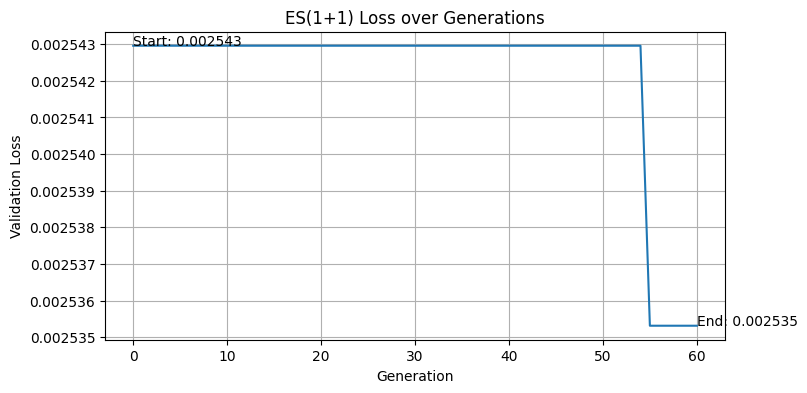

In [43]:
plt.figure(figsize=(8,4))
plt.plot(es_loss_history)
plt.title("ES(1+1) Loss over Generations")
plt.xlabel("Generation")
plt.ylabel("Validation Loss")
plt.annotate(f"Start: {es_loss_history[0]:.6f}",
             xy=(0, es_loss_history[0]))
plt.annotate(f"End: {es_loss_history[-1]:.6f}",
             xy=(len(es_loss_history)-1, es_loss_history[-1]))
plt.grid(True)
plt.show()


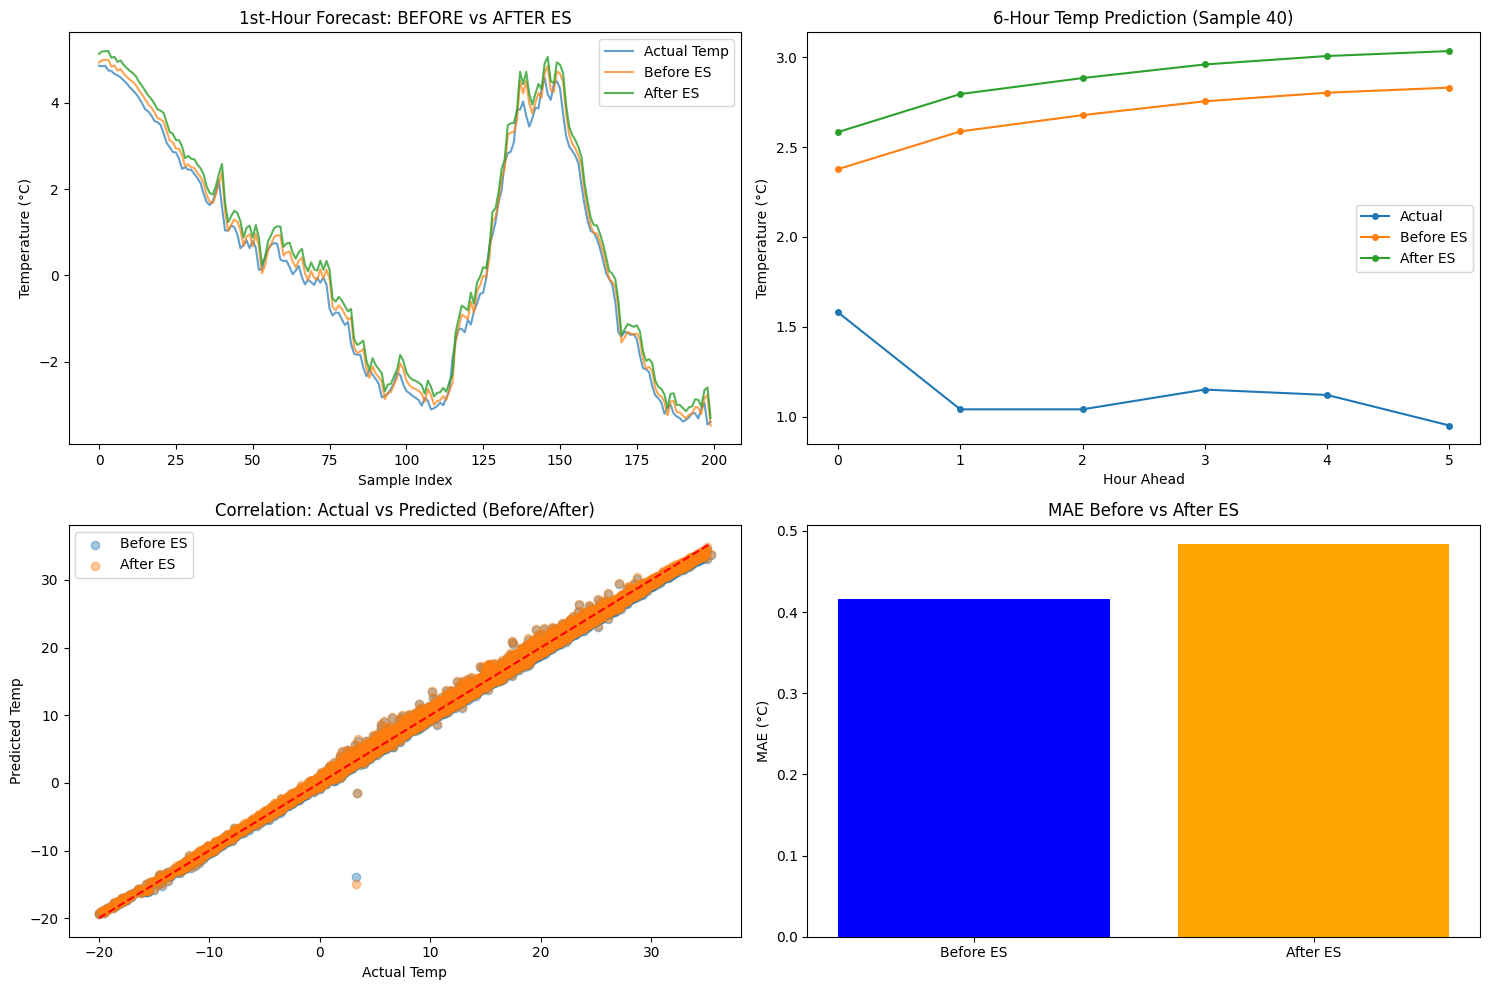

MAE Before ES: 0.4160642029228663
MAE After ES: 0.48333333641550474


In [44]:
# ============================================================
# BEFORE vs AFTER ES(1+1) PREDICTION COMPARISON
# ============================================================

# Load BEFORE ES predictions (already saved earlier)
y_pred_inv_before = np.load("y_pred_inv_before.npy")
y_test_inv_before = np.load("y_test_inv_before.npy")

# AFTER ES predictions already computed:
# y_pred_inv_after

# Choose a sample index for multi-step visualization
seq_idx = 40
time_steps = np.arange(future_steps)

plt.figure(figsize=(15, 10))

# ------------------------------------------------------------
# 1. First-step prediction comparison (Temperature)
# ------------------------------------------------------------
plt.subplot(2, 2, 1)
plt.plot(y_test_inv_before[:200, 0, 0], label='Actual Temp', alpha=0.7)
plt.plot(y_pred_inv_before[:200, 0, 0], label='Before ES', alpha=0.7)
plt.plot(y_pred_inv_after[:200, 0, 0], label='After ES', alpha=0.8)
plt.title('1st-Hour Forecast: BEFORE vs AFTER ES')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()

# ------------------------------------------------------------
# 2. Multi-step (6-hour) sequence comparison for one sample
# ------------------------------------------------------------
plt.subplot(2, 2, 2)
plt.plot(time_steps, y_test_inv_before[seq_idx, :, 0], 'o-', label='Actual', markersize=4)
plt.plot(time_steps, y_pred_inv_before[seq_idx, :, 0], 'o-', label='Before ES', markersize=4)
plt.plot(time_steps, y_pred_inv_after[seq_idx, :, 0], 'o-', label='After ES', markersize=4)
plt.title(f'6-Hour Temp Prediction (Sample {seq_idx})')
plt.xlabel('Hour Ahead')
plt.ylabel('Temperature (°C)')
plt.legend()

# ------------------------------------------------------------
# 3. Scatter comparison before vs after
# ------------------------------------------------------------
plt.subplot(2, 2, 3)
plt.scatter(y_test_inv_before[:, 0, 0], y_pred_inv_before[:, 0, 0],
            alpha=0.4, label='Before ES')
plt.scatter(y_test_inv_before[:, 0, 0], y_pred_inv_after[:, 0, 0],
            alpha=0.4, label='After ES')

min_v = y_test_inv_before[:, 0, 0].min()
max_v = y_test_inv_before[:, 0, 0].max()
plt.plot([min_v, max_v], [min_v, max_v], 'r--')

plt.title('Correlation: Actual vs Predicted (Before/After)')
plt.xlabel('Actual Temp')
plt.ylabel('Predicted Temp')
plt.legend()

# ------------------------------------------------------------
# 4. MAE before vs after ES
# ------------------------------------------------------------
mae_before = mean_absolute_error(y_test_inv_before[:, :, 0].flatten(),
                                 y_pred_inv_before[:, :, 0].flatten())

mae_after = mean_absolute_error(y_test_inv_before[:, :, 0].flatten(),
                                y_pred_inv_after[:, :, 0].flatten())

plt.subplot(2, 2, 4)
plt.bar(['Before ES', 'After ES'], [mae_before, mae_after], color=['blue', 'orange'])
plt.title('MAE Before vs After ES')
plt.ylabel('MAE (°C)')

plt.tight_layout()
plt.show()

print("MAE Before ES:", mae_before)
print("MAE After ES:", mae_after)


## 8. Evaluation, Visualizations, and Metrics

Here I look at training curves, GA and ES behaviour, and final forecast quality.


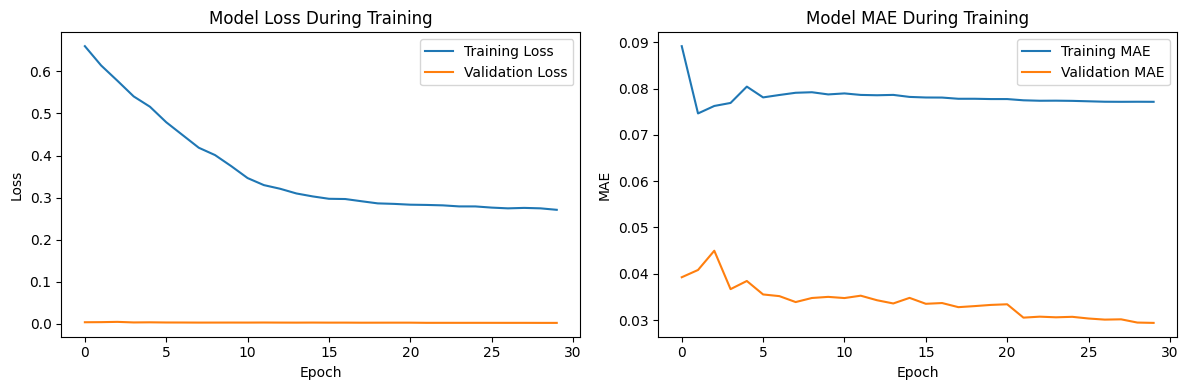

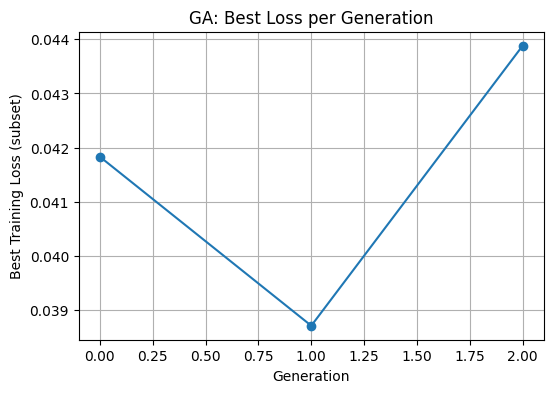

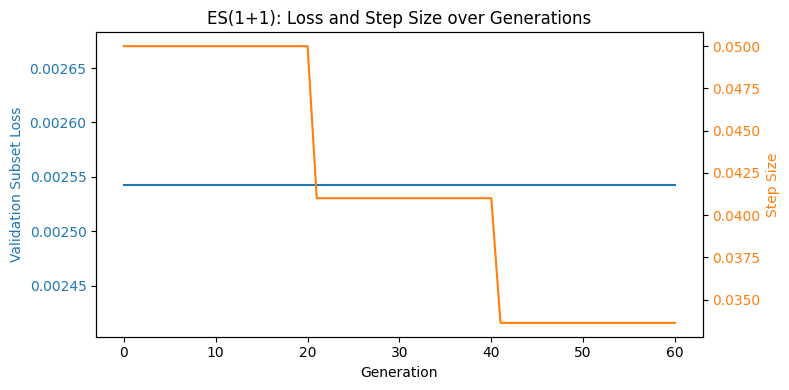

In [25]:
# Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# GA best loss per generation
plt.figure(figsize=(6, 4))
plt.plot(ga_history, marker='o')
plt.title('GA: Best Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Best Training Loss (subset)')
plt.grid(True)
plt.show()

# ES loss and step size curves
gens = np.arange(len(es_loss_history))
fig, ax1 = plt.subplots(figsize=(8, 4))
color = 'tab:blue'
ax1.set_xlabel('Generation')
ax1.set_ylabel('Validation Subset Loss', color=color)
ax1.plot(gens, es_loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Step Size', color=color)
ax2.plot(gens, es_step_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('ES(1+1): Loss and Step Size over Generations')
fig.tight_layout()
plt.show()


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


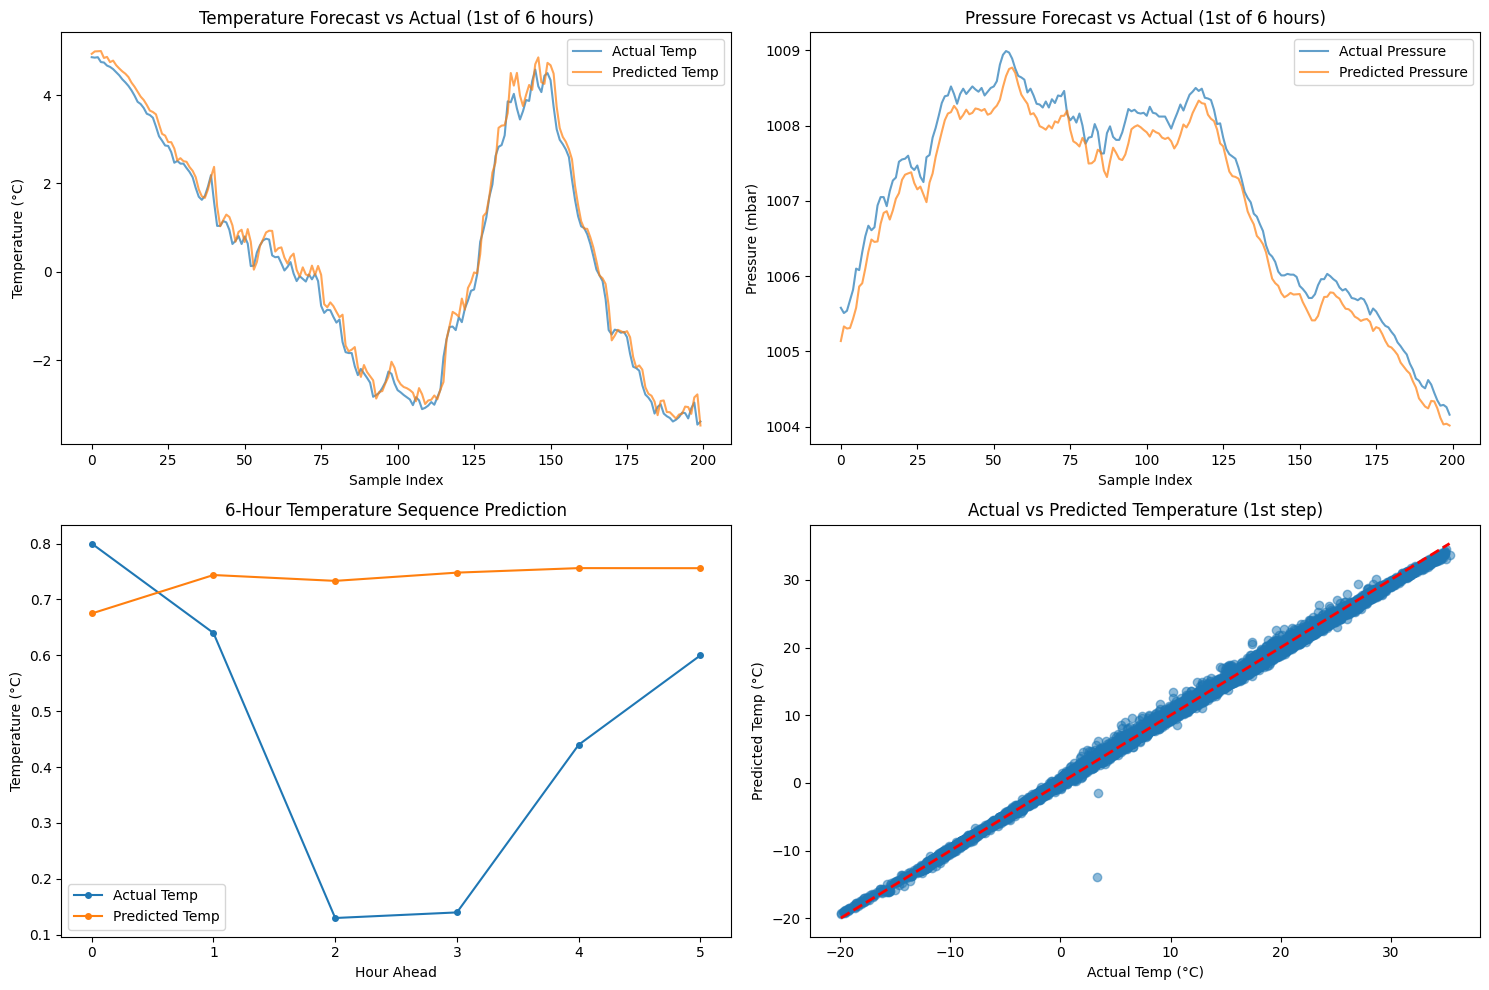

PERFORMANCE METRICS (AFTER GA + ES)
Temperature:
  MAE:  0.416
  RMSE: 0.593
  R²:   0.994

Pressure:
  MAE:  0.219
  RMSE: 0.307
  R²:   0.999

Density:
  MAE:  1.762
  RMSE: 2.606
  R²:   0.995

Wind Speed:
  MAE:  0.749
  RMSE: 28.368
  R²:   -0.054

Max Wind Speed:
  MAE:  0.914
  RMSE: 6.880
  R²:   -6.771

OVERALL:
  MAE:  0.812
  RMSE: 13.110
  R²:   0.999


In [26]:
# Evaluate on test set and visualize predictions
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    batch_size = 512
else:
    batch_size = 32

test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test.astype('float32'), y_test.astype('float32'))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

y_pred = final_model.predict(test_ds)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, X.shape[2]))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, X.shape[2]))
y_test_inv = y_test_inv.reshape(y_test.shape)
y_pred_inv = y_pred_inv.reshape(y_pred.shape)

plt.figure(figsize=(15, 10))
sample_size = min(200, len(y_test_inv))

# Temp first step
plt.subplot(2, 2, 1)
plt.plot(y_test_inv[:sample_size, 0, 0], label='Actual Temp', alpha=0.7)
plt.plot(y_pred_inv[:sample_size, 0, 0], label='Predicted Temp', alpha=0.7)
plt.title('Temperature Forecast vs Actual (1st of 6 hours)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()

# Pressure first step
plt.subplot(2, 2, 2)
plt.plot(y_test_inv[:sample_size, 0, 1], label='Actual Pressure', alpha=0.7)
plt.plot(y_pred_inv[:sample_size, 0, 1], label='Predicted Pressure', alpha=0.7)
plt.title('Pressure Forecast vs Actual (1st of 6 hours)')
plt.xlabel('Sample Index')
plt.ylabel('Pressure (mbar)')
plt.legend()

# Multi-step temp sequence for one sample
plt.subplot(2, 2, 3)
seq_idx = min(50, len(y_test_inv) - 1)
time_steps = np.arange(future_steps)
plt.plot(time_steps, y_test_inv[seq_idx, :, 0], 'o-', label='Actual Temp', markersize=4)
plt.plot(time_steps, y_pred_inv[seq_idx, :, 0], 'o-', label='Predicted Temp', markersize=4)
plt.title('6-Hour Temperature Sequence Prediction')
plt.xlabel('Hour Ahead')
plt.ylabel('Temperature (°C)')
plt.legend()

# Correlation actual vs predicted (first step)
plt.subplot(2, 2, 4)
plt.scatter(y_test_inv[:, 0, 0], y_pred_inv[:, 0, 0], alpha=0.5)
min_val = min(y_test_inv[:, 0, 0].min(), y_pred_inv[:, 0, 0].min())
max_val = max(y_test_inv[:, 0, 0].max(), y_pred_inv[:, 0, 0].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.title('Actual vs Predicted Temperature (1st step)')
plt.xlabel('Actual Temp (°C)')
plt.ylabel('Predicted Temp (°C)')

plt.tight_layout()
plt.show()

print("="*50)
print("PERFORMANCE METRICS (AFTER GA + ES)")
print("="*50)

feature_names = ["Temperature", "Pressure", "Density", "Wind Speed", "Max Wind Speed"]

for i, feature in enumerate(feature_names):
    y_true = y_test_inv[:, :, i].flatten()
    y_pred_flat = y_pred_inv[:, :, i].flatten()
    mae = mean_absolute_error(y_true, y_pred_flat)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_flat))
    r2 = r2_score(y_true, y_pred_flat)
    print(f"{feature}:")
    print(f"  MAE:  {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²:   {r2:.3f}\n")

all_true = y_test_inv.flatten()
all_pred = y_pred_inv.flatten()
overall_mae = mean_absolute_error(all_true, all_pred)
overall_rmse = np.sqrt(mean_squared_error(all_true, all_pred))
overall_r2 = r2_score(all_true, all_pred)

print("OVERALL:")
print(f"  MAE:  {overall_mae:.3f}")
print(f"  RMSE: {overall_rmse:.3f}")
print(f"  R²:   {overall_r2:.3f}")


## 9. Reflection and Discussion (Student Perspective)

In this project I combined what I learned about **time-series**, **Seq2Seq LSTMs**, and **evolutionary algorithms** into a single experiment.

- I used 72 hours of past weather data to predict the next 6 hours.
- I used a GA to automatically search for good hyperparameters.
- I used ES(1+1) with the 1/5 success rule to fine-tune the last layer weights.

This helped me see how evolutionary methods can sit on top of neural networks (for hyperparameters) and also inside them (for weights), and how the ideas from the lectures actually look in code and in plots.
